## Intersection - Test Bench
This  notebook is used to evaluate the performance regarding intersection operations of a compression algorithm.

NOTE: correctness is not checked here. That is done in "Intersection_Sketching.ipynb".

It is written such that a new compression algorithm can be added without altering the bench (just change the input in the config).

In [1]:
# ADD NEW ALGORITHMS HERE
from algos.alg_wkt import Wkt
from algos.alg_wkb import Wkb
from algos.alg_meta_wkb_comp import MetaWkbComp # Wkb with Metadat
from algos.alg_meta_wkt_comp import MetaWktComp # Wkt with Metadat
from algos.alg_wkb_comp import WkbComp
from algos.alg_wkt_comp import WktComp
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
import algos.fpd_extended_lib.cfg as cfg

# CONFIG
ALG = FpdExtended()

NBR_ITER = 1000

In [2]:
import time
import os
from enum import Enum
import pandas as pd
from datetime import datetime
import filecmp
import random
import json
import tqdm
from shapely.geometry import shape
import glob
import timeit
import shapely
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from intersection.chunk_bbox_intersection import common_bbox
import geopandas as gpd
from bench_utils import parse_intersection_data 


In [3]:
# List the metrics which are to be logged
ET = Enum('ET', ['NO_BBOX', 'FALSE_IN_BBOX', 'TRUE_NO_CONTAINS', 'CONTAINS'
]) # EVAL_TYPE

ST = Enum('ET', ['SMALL', 'MIXED', 'LARGE'
]) # EVAL_TYPE

### Benchmarking
Run the compression, decompression, along with the operations, and store the measurements. Done NBR_ITER times to average.

In [4]:
N = 1

manual_data, _ = parse_intersection_data("manual")
world_data, world_data_stats = parse_intersection_data("world.json")
lund_data, lund_data_stats = parse_intersection_data("lund.json")
tricky_data, tricky_data_stats = parse_intersection_data("latest_export.json")

ALG_FPDE = FpdExtended()
def evaluate_dataset(data, chk_max_size=None):

    if  chk_max_size != None:
        cfg.MAX_NUM_DELTAS = chk_max_size

    max_idx = len(data) - 1
    idxs = [random.randint(0, max_idx) for i in range(NBR_ITER)] # Generate list of indexes to query on
    
    geom_vertex_cnt = []
    for i in tqdm.tqdm(idxs):
        g1, g2 = data[i]
        geom_vertex_cnt.append([shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2)])
        _, b1 = ALG.compress(g1)
        _, b2 = ALG.compress(g2)
        t_pred = timeit.timeit(lambda: ALG.is_intersecting((b1, b2)), number=N) / N
        t_shape = timeit.timeit(lambda: ALG.intersection((b1, b2)), number=N) / N

        b1_fpde = b1
        b2_fpde = b2
        if ALG != FpdExtended:
            _, b1_fpde = ALG_FPDE.compress(g1)
            _, b2_fpde = ALG_FPDE.compress(g2) 
        bbox = common_bbox((b1_fpde, b2_fpde))
        intersects = shapely.intersection(g1, g2)
        contains = shapely.contains(g1, g2) or shapely.contains(g2, g1)
        if not bbox:
            et = ET.NO_BBOX
        elif not intersects:
            et = ET.FALSE_IN_BBOX
        elif not contains:
            et = ET.TRUE_NO_CONTAINS
        else:
            et = ET.CONTAINS

        LARGE_THRESHOLD = 50
        s1, s2 = (shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2))
        if s1 < LARGE_THRESHOLD and s2 < LARGE_THRESHOLD:
            sz = ST.SMALL
        elif s1 >= LARGE_THRESHOLD and s2 >= LARGE_THRESHOLD:
            sz = ST.LARGE
        else:
            sz = ST.MIXED

        res.append(('PRED_' + str(sz)[3:] + '_' + str(et)[3:], t_pred))
        res.append(('SHAPE_' + str(sz)[3:] + '_' + str(et)[3:], t_shape))
    print(np.average(geom_vertex_cnt))
    print(geom_vertex_cnt)
res = []
# evaluate_dataset(manual_data) # Second param: PLOT?
#evaluate_dataset(world_data, chk_max_size=17)
evaluate_dataset(lund_data, chk_max_size=15)
#evaluate_dataset(tricky_data,17)

SEED = 123 # If we want to enforce the same ordering and indexes for multiple runs, else None
#SEED = random.randint(0, 9999999999999999)
random.seed(SEED) # Init random

df = pd.DataFrame(res, columns=['type', 'time'])
#df

### Plot the Results

In [ ]:
averages = df.copy()
averages.loc['mean'] = averages.mean(numeric_only=True)
averages = averages.iloc[-1]

baseline_file = 'intersection_baseline.csv'
if os.path.exists(baseline_file):
    baseline = pd.read_csv(baseline_file)
    baseline['Algorithm'] = 'Baseline'
else:
    baseline_file = None

Total time for Baseline: 10.934316868999375
Total time for FpdExtended: 6.73464011300004


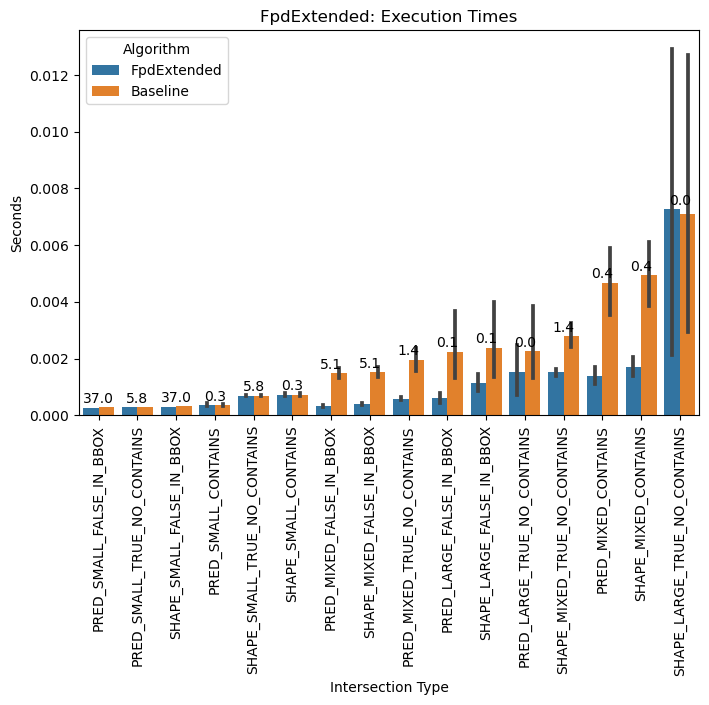

In [ ]:
SHOW_PREVIOUS = False

times = df.copy()
times['Algorithm'] = ALG.__class__.__name__

if baseline_file != None:
    times = pd.concat([times, baseline])
    total_time = sum(baseline["time"])
    print(f"Total time for Baseline: {total_time}")

prevs = glob.glob(f'reports/intersection_{ALG.__class__.__name__}*')
if len(prevs) != 0 and SHOW_PREVIOUS:
    prevs.sort()
    prev = pd.read_csv(prevs[-1])
    prev['Algorithm'] = 'Previous'
    times = pd.concat([times, prev])
    
times_order = times.groupby('type').apply(lambda x: x.time.mean()).sort_values().keys()
percent = (times.type.value_counts(normalize=True) * 100).apply(lambda x: round(x, 1))

times_algo_avg = times.groupby(['type', 'Algorithm']).apply(lambda x: x.time.mean())
plt.figure(figsize=(8, 5))
for idx, i in enumerate(times_order):
    plt.annotate(percent[i], (idx, max(times_algo_avg[i]) + 0.00005), ha="center", va="bottom")
sns.barplot(data=times, x="type", y='time', hue="Algorithm", order=times_order)

plt.xticks(rotation=90)
plt.ylabel('Seconds');
plt.xlabel('Intersection Type');
plt.title(ALG.__class__.__name__ + ": Execution Times");

total_time = sum(df["time"])
print(f"Total time for {ALG.__class__.__name__ }: {total_time}")

### Export to CSV

In [ ]:
#df.to_csv("reports/intersection_" + ALG.__class__.__name__ + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + ".csv", index=False)
df.to_csv("intersection_baseline.csv", index=False)